In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

import warnings
import pickle

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def read_json_df(path):
    json = pd.read_json(r"{}".format(path))
    df_apartments = json[['id', 'floor', 'beds', 'price', 'size_m2']]
    
    df_tags = json.explode('tags').dropna(subset=['tags'])
    df_tags['tag_category'] = df_tags['tags'].apply(lambda x: x['tag_category'])
    df_tags['tag_value'] = df_tags['tags'].apply(lambda x: x['tag_value'])
    
    df_tags = df_tags.pivot_table(index='id',
                                  columns='tag_category', 
                                  values='tag_value', 
                                  aggfunc='first').reset_index()
    
    df = df_apartments.merge(df_tags, on='id', how='left')
    return df


df = read_json_df("for_sale_apartments.json")
features = df.drop("id",axis=1).columns

new_df = df[features]

In [3]:
scaler = pickle.load(open("for_sale_preprocessor.pkl","rb"))
scaled_df = scaler.transform(new_df)

In [4]:
with open('for_sale_clustering_model.pkl', 'rb') as f:
    clustering = pickle.load(f)
    tsne = clustering['tsne']
    kmeans = clustering['kmeans']

In [5]:
tsne_results = tsne.fit_transform(scaled_df)
kmeans.fit(tsne_results)
labels = kmeans.labels_

## User Data Example

In [6]:
df.head(1)

,id,floor,beds,price,size_m2,families,light_trail,parks,quiet_street,religious,school,secular
0,d3dbVQErVCp,6,4,5290000,106,1.0,3.0,3.0,5.0,2.0,1.0,1.0


In [7]:
user_prefs = pd.DataFrame({
    "floor":[2],
    "beds":[4],
    "price":[3000000],
    "size_m2":[90],
    "families":[4],
    "light_trail":[4],
    "parks":[4],
    "quiet_street":[3],
    "religious":[3],
    "school":[4],
    "secular":[3]
})

In [8]:
display(user_prefs)

,floor,beds,price,size_m2,families,light_trail,parks,quiet_street,religious,school,secular
0,2,4,3000000,90,4,4,4,3,3,4,3


In [9]:
user_prefs_scaled = scaler.transform(user_prefs)
combined_data = np.vstack([scaled_df, user_prefs_scaled])
tsne_combined_results = tsne.fit_transform(combined_data)

tsne_results = tsne_combined_results[:-1]
user_prefs_tsne_results = tsne_combined_results[-1]

kmeans.fit(tsne_results)
labels = kmeans.labels_

user_prefs_label = kmeans.predict(user_prefs_tsne_results.reshape(1, -1))

print("User is in cluster:",user_prefs_label[0])

User is in cluster: 4


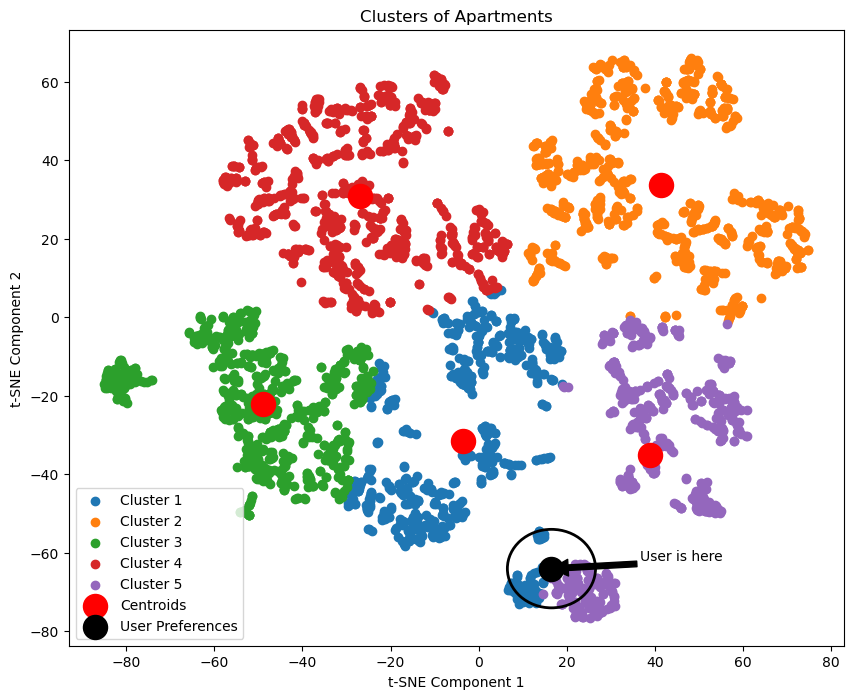

In [10]:
plt.figure(figsize=(10, 8))
for i in range(len(kmeans.cluster_centers_)):
    plt.scatter(tsne_results[labels == i, 0], tsne_results[labels == i, 1], label=f'Cluster {i+1}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')

plt.scatter(user_prefs_tsne_results[0], user_prefs_tsne_results[1], s=300, c='black', label='User Preferences')

circle = plt.Circle((user_prefs_tsne_results[0], user_prefs_tsne_results[1]), 10, color='black', fill=False, linewidth=2)
plt.gca().add_artist(circle)

plt.annotate('User is here',
             xy=(user_prefs_tsne_results[0], user_prefs_tsne_results[1]), 
             xytext=(user_prefs_tsne_results[0] + 20, user_prefs_tsne_results[1] + 2),
             arrowprops=dict(facecolor='black', shrink=5))

plt.title('Clusters of Apartments')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import pairwise_distances
import numpy as np

# Assuming tsne_combined_results contains the t-SNE results including the user's preferences
user_index = -1  # Index of user's preferences in the combined data
user_tsne_position = tsne_combined_results[user_index]

# Filter apartments in the user's cluster 
user_cluster = user_prefs_label[0]
user_cluster_indices = np.where(labels == user_cluster)[0]
cluster_apartments_tsne = tsne_results[user_cluster_indices]

# Calculate Euclidean distances between the user's preferences and each apartment in the cluster
distances = pairwise_distances(cluster_apartments_tsne, user_tsne_position.reshape(1, -1), metric='euclidean').flatten()

# Normalize the distances to get similarity scores (0 means identical, higher values mean less similar)
max_distance = distances.max()
similarity_scores = 1 - (distances / max_distance)

# Create a DataFrame with the original apartment data and similarity scores
cluster_apartments = df.iloc[user_cluster_indices].copy()
cluster_apartments['similarity_score'] = similarity_scores


In [12]:
top_n_apartments = cluster_apartments.nlargest(20, 'similarity_score')

In [13]:
top_n_apartments

,id,floor,beds,price,size_m2,families,light_trail,parks,quiet_street,religious,school,secular,similarity_score
503,iX39GB4A4gF,3,4,3500000,88,4.0,3.0,3.0,3.0,4.0,4.0,4.0,0.988909
773,eoySRwXRvgZ,3,6,5500000,196,3.0,3.0,3.0,2.0,4.0,4.0,5.0,0.978928
718,eyqf62gCOfu,0,5,3600000,110,4.0,2.0,3.0,3.0,4.0,4.0,4.0,0.978432
719,c4dkcs7Zgng,0,5,3600000,110,3.0,3.0,4.0,2.0,4.0,4.0,5.0,0.977593
980,dDigVmtMGy6,2,4,3000000,80,4.0,2.0,3.0,2.0,4.0,4.0,4.0,0.976386
83,bRZk9BNmQcc,0,5,3780000,110,4.0,2.0,3.0,1.0,4.0,4.0,4.0,0.972635
624,d1iDIpN8lNp,2,5,5490000,123,4.0,1.0,4.0,1.0,4.0,4.0,4.0,0.966861
602,efjKFVH9qs1,4,6,12500000,215,4.0,1.0,3.0,2.0,4.0,4.0,5.0,0.954773
558,kmCC2dQTT4b,7,4,10780000,122,3.0,2.0,4.0,2.0,4.0,4.0,5.0,0.953553
692,hUyty9YLCdV,4,2,2800000,45,4.0,2.0,4.0,1.0,4.0,4.0,4.0,0.943966


In [14]:
user_prefs

,floor,beds,price,size_m2,families,light_trail,parks,quiet_street,religious,school,secular
0,2,4,3000000,90,4,4,4,3,3,4,3


##### Top Apartment Match:

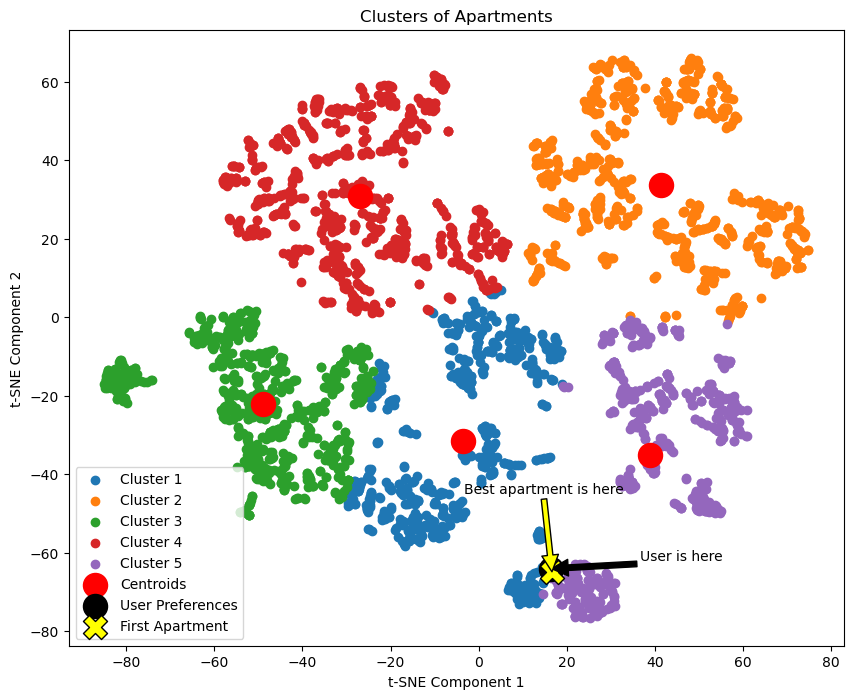

In [15]:
first_apartment_index = top_n_apartments.index[0]
first_apartment_tsne = tsne_results[first_apartment_index]

plt.figure(figsize=(10, 8))
for i in range(len(kmeans.cluster_centers_)):
    plt.scatter(tsne_results[labels == i, 0], tsne_results[labels == i, 1], label=f'Cluster {i+1}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')

plt.scatter(user_prefs_tsne_results[0], user_prefs_tsne_results[1], s=300, c='black', label='User Preferences')

# Highlight the first apartment
plt.scatter(first_apartment_tsne[0], first_apartment_tsne[1], s=300, c='yellow', edgecolors='black', label='First Apartment', marker='X')


plt.annotate('User is here',
             xy=(user_prefs_tsne_results[0], user_prefs_tsne_results[1]), 
             xytext=(user_prefs_tsne_results[0] + 20, user_prefs_tsne_results[1] + 2),
             arrowprops=dict(facecolor='black', shrink=5))

plt.annotate('Best apartment is here',
             xy=(first_apartment_tsne[0], first_apartment_tsne[1]), 
             xytext=(first_apartment_tsne[0] -20 , first_apartment_tsne[1] + 20),
             arrowprops=dict(facecolor='yellow', shrink=5))

plt.title('Clusters of Apartments')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()